In [67]:
!pip install --upgrade jax diffrax equinox optax numpy

In [68]:
import h5py
import pandas as pd

import diffrax as dfx  # http://github.com/patrick-kidger/diffrax
import equinox as eqx  # http://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import jax.random as jr
import optax  # http://github.com/deepmind/optax
import numpy as np

import matplotlib.pyplot as plt

import glob

from jax import random

jax.config.update("jax_enable_x64", True)

In [69]:
def get_simulation_parameters():
  return pd.read_csv("data/grid_parameters.csv", index_col=0)

def load_data(idx):
  with h5py.File(f"one_sample.h5") as fh:
    return jnp.array(fh["data"][:])

In [70]:
class LoadOneSample:
  def __init__(self, timesteps_per_batch, skip_first_samples=True):
    """Dataloader that loads one timeseries, then splits it up and return it in batches.
      Args:
        timesteps_per_batch: int, number of timesteps per batch
        sample_to_load: int, which sample to load from the directory
        skip_first_samples: bool, whether to skip the first samples if False, it will skip the last ones."""
    with h5py.File(f"one_sample.h5") as fh:
      x = np.array(fh["data"][:])
      eps = 1e-20
      dt = jnp.diff(x[0])
      x = np.log10(x + eps)
      nsp=17
      # Normalization of the chemical evolution:
      for i in range(nsp):
        #it is numpy, i guess same for jnp
        min_, max_ = np.amin(x[i+1,:]), np.amax(x[i+1,:])
        x[i+1,:]  = 2.*(x[i+1,:] - min_ )/(max_ - min_ )-1.
    self.x_now = jnp.array(x[:, :-1])
    self.x_next = jnp.array(x[:, 1:])
    self.dt = jnp.array(dt)
    self.timesteps_per_batch = timesteps_per_batch
    total_timesteps = self.x_now.shape[-1]
    self.skip_first_samples = skip_first_samples
    if self.skip_first_samples:
      self.slices = np.arange(total_timesteps%timesteps_per_batch, total_timesteps, timesteps_per_batch) + [timesteps_per_batch]
    else:
      self.slices = np.arange(0, total_timesteps, self.timesteps_per_batch)

  def __len__(self):
    return len(self.slices)-1

  def __getitem__(self, idx):
    """Returns a batch of data.
      Args:
        idx: int, index of the batch
      Returns:
        (dt, x_now, x_next) where dt is the time difference between the current and next timestep"""
    return self.dt[self.slices[idx]:self.slices[idx+1]], self.x_now[1:, self.slices[idx]:self.slices[idx+1]].T, self.x_next[1:, self.slices[idx]:self.slices[idx+1]].T

In [71]:
# Test the dataset and its shapes
dl = LoadOneSample(10)
a, b, c = dl[0]
print(a.shape, b.shape, c.shape)


(10,) (10, 17) (10, 17)


In [73]:
# Create a NeuralODE in Jax and train it to solve the ODE dy/dt = f(y) where f is a neural network:

model_key = jr.PRNGKey(0)

@eqx.filter_jit
def solve(model, y0, t0, t1):
  print("Compiling solve")
  term = dfx.ODETerm(lambda t, y, args: model(y)) #rhs of dy/dt = f(y,t)
  # We need a stiff solver
  solver= dfx.Kvaerno5()
  stepsize_controller = dfx.PIDController(rtol=1e-6, atol=1e-6)
  sol = dfx.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=0.01*t1, y0=y0, stepsize_controller=stepsize_controller, max_steps=25000)
  (y1,) = sol.ys
  return y1

def loss(model, batch_y0, batch_y1, timestep):
  print("Compiling loss")
  pred_batch_y1 = eqx.filter_vmap(solve, in_axes=(None, 0, None, 0))(model, batch_y0, 0.0, timestep)
  loss = jnp.mean((pred_batch_y1 - batch_y1)**2)
  return loss

@eqx.filter_jit
def make_step(model, opt_state, batch_y0, batch_y1, timestep):
  print("Compiling step")
  grads = eqx.filter_grad(loss)(model, batch_y0, batch_y1, timestep)
  value, grads = eqx.filter_value_and_grad(loss)(model, batch_y0, batch_y1, timestep)
  updates, opt_state = optim.update(grads, opt_state)
  model = eqx.apply_updates(model, updates) 
  return value, model, opt_state

mlp = eqx.nn.MLP(in_size=17, out_size="scalar", width_size=10, depth=1, key=model_key, activation = jax.nn.softplus, final_activation = jnp.tanh)
optim = optax.adam(learning_rate=3e-4)
opt_state = optim.init(eqx.filter(mlp, eqx.is_array))
samples_per_batch = 5
try: 
  # Train on one sample:
  dataloader = LoadOneSample(samples_per_batch)

  for epoch in range(10):
    
    loss_per_epoch = 0.0

    for step, (timestep, batch_y0, batch_y1) in enumerate(dataloader):
      value, mlp, opt_state = make_step(mlp, opt_state, batch_y0, batch_y1, timestep)
      # print(f"Loss for sample {step}: {value}")
      loss_per_epoch += value
    print(f"Epoch: {epoch}, Loss: {loss_per_epoch/step}")   
  print(f"Converged for {samples_per_batch} samples per batch, final loss is {loss_per_epoch/step}")
except ValueError:
  print(f"Failed to converge for {samples_per_batch} samples per batch") 

Compiling step
Compiling loss
Compiling solve
Compiling loss
Epoch: 0, Loss: 706.6758639743671
Epoch: 1, Loss: 0.08354814028418231
Epoch: 2, Loss: 0.08352348592994628
Epoch: 3, Loss: 0.08348395218803634
Epoch: 4, Loss: 0.08342333458682255
Epoch: 5, Loss: 0.08333205623443268
Epoch: 6, Loss: 0.08319584136391565
Epoch: 7, Loss: 0.08299377466271825
Epoch: 8, Loss: 0.08269568884983541
Epoch: 9, Loss: 0.08225891120807743
Converged for 5 samples per batch, final loss is 0.08225891120807743


In [74]:
# Now perform inference from one step to the next:
samples_per_batch = 1
dataloader = LoadOneSample(samples_per_batch)
results = []
for step, (timestep, batch_y0, batch_y1) in enumerate(dataloader):
    # solve(mlp, batch_y0, 0, timestep)
    results.append((eqx.filter_vmap(solve, in_axes=(None, 0, None, 0))(mlp, batch_y0, 0.0, timestep), batch_y1))

In [75]:
# Unpack the results:
pred = np.array([result[0] for result in results]).squeeze()
true = np.array([result[1] for result in results]).squeeze()


In [76]:
with h5py.File("one_sample.h5") as fh:
    time = fh["data"][0, :]
# Choose some colors:
colors_rgb = [
    "#082567",   # Sapphire Blue
    "#008F39",   # Emerald Green
    "#A20025",   # Crimson Red
    "#DAA520",   # Goldenrod Yellow
    "#B57EDC",   # Lavender Purple
    "#FF664D",   # Coral Orange
    "#008080",   # Teal Blue
    "#FF0090",   # Magenta Pink
    "#4B0082",   # Indigo Violet
    "#FFBF00",   # Amber Gold
    "#8B0000",   # Ruby Red
    "#00FFFF",   # Cyan Blue
    "#E8A200",   # Marigold Yellow
    "#DA70D6",   # Orchid Purple
    "#FFA500",   # Tangerine Orange
    "#40E0D0",   # Turquoise Blue
    "#000000",   # Mauve Pink
]
time = time[2:]
# The column names:
names = ["C", "C+", "CO", "CO+", "E", "H", "H+", "H2", "H2O", "H2O+", "H3O+", "HCO+", "O2", "O+", "OH4", "OH+", "Tgas"]

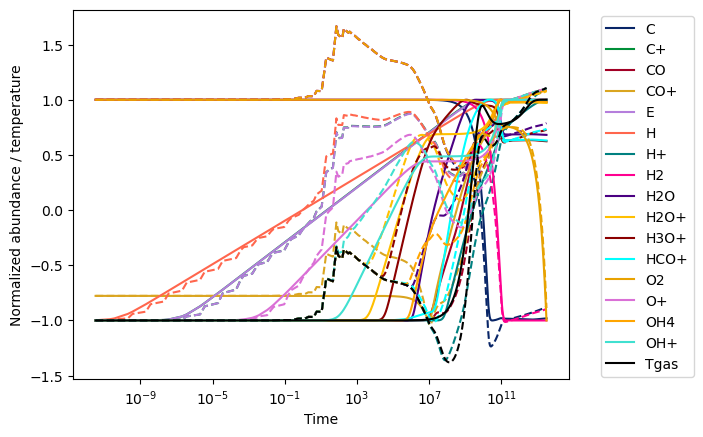

In [77]:
for true_, pred_, color, name in zip(true.T, pred.T, colors_rgb, names):
    plt.plot(time, true_, label=f"{name}", color=color)
    plt.plot(time, pred_, linestyle="dashed",color=color)
plt.xscale("log")
plt.xlabel("Time")
plt.ylabel("Normalized abundance / temperature")    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


Text(0, 0.5, 'MSE over time')

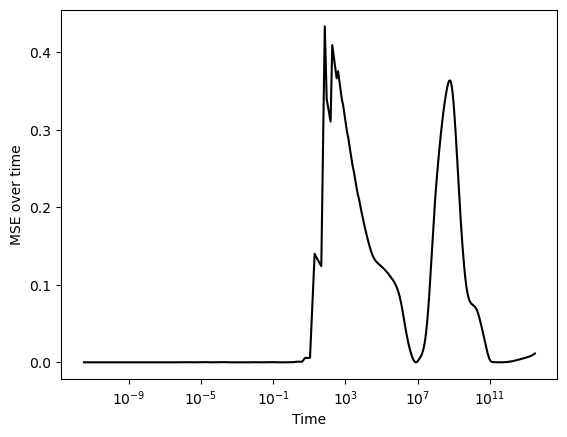

In [78]:
plt.plot(time, np.mean(true-pred, axis=1)**2, label="{name}", color=color)
plt.xscale("log")
plt.xlabel("Time")
plt.ylabel("MSE over time")